## Setup

In [1]:
!git clone https://github.com/neuspell/neuspell
%cd neuspell

fatal: destination path 'neuspell' already exists and is not an empty directory.
/content/neuspell


In [2]:
!pip install -e .

Obtaining file:///content/neuspell
  Found existing installation: neuspell 1.0.0
    Can't uninstall 'neuspell'. No files were found to uninstall.
  Running setup.py develop for neuspell


In [3]:
!pip install urllib3==1.25.4
!pip install folium==0.2.1
!pip install -r extras-requirements.txt
!pip install torch==1.6.0
!pip install transformers==4.1

import neuspell
%cd data/traintest
!python download_datafiles.py 
%cd /content/neuspell

Obtaining file:///content/neuspell (from -r extras-requirements.txt (line 1))
Obtaining file:///content/neuspell (from -r extras-requirements.txt (line 2))
  Found existing installation: neuspell 1.0.0
    Can't uninstall 'neuspell'. No files were found to uninstall.
  Running setup.py develop for neuspell
data folder is set to `/content/neuspell/neuspell/../data` script
/content/neuspell/data/traintest
./wo_context already exists
/content/neuspell


## Data preparation

In [4]:
from tqdm import tqdm
import os, sys
import numpy as np
# import re
import time
# from typing import List

import torch
# from torch import nn
# from torch.nn.utils.rnn import pad_sequence
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# import torch.nn.functional as F

from neuspell.seq_modeling.helpers import progressBar
from neuspell.seq_modeling.helpers import load_vocab_dict, save_vocab_dict
from neuspell.seq_modeling.helpers import load_data, train_validation_split, get_tokens, num_unk_tokens #, get_char_tokens
from neuspell.seq_modeling.helpers import batch_iter, labelize, char_tokenize #, tokenize
from neuspell.seq_modeling.helpers import untokenize_without_unks, untokenize_without_unks2, get_model_nparams #, untokenize
from neuspell.seq_modeling.helpers import batch_accuracy_func

from neuspell.seq_modeling.helpers2 import get_line_representation, get_lines

from neuspell.seq_modeling.models import CharLSTMWordLSTMModel

from neuspell.seq_modeling.evals import get_metrics
import matplotlib.pyplot as plt

from neuspell.seq_modeling.lstmlstm import load_model
from neuspell.seq_modeling.lstmlstm import model_inference
from neuspell.seq_modeling.lstmlstm import model_predictions

In [5]:
train_data = load_data('/content/neuspell/data/traintest/','test.1blm','test.1blm.noise.prob')

273134it [00:00, 347413.05it/s]
273134it [00:00, 1462901.61it/s]

loaded tuples of (corr,incorr) examples from /content/neuspell/data/traintest/


In [6]:
train_data, valid_data = train_validation_split(train_data, 0.90, seed=1)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model training

In [8]:
# load a vocab for reference
vocab_ref = {}
vocab = get_tokens([i[0] for i in train_data],
          keep_simple=True,
          min_max_freq=(2,float("inf")),
          topk=100000,
          intersect=vocab_ref,
          load_char_tokens=True)

100%|██████████| 245821/245821 [00:01<00:00, 153455.25it/s]


Total tokens found: 155272


  0%|          | 0/245821 [00:00<?, ?it/s]

Total tokens retained: 139243
Total tokens retained: 67965
Total tokens retained: 67965
loading character tokens


100%|██████████| 245821/245821 [00:01<00:00, 202378.53it/s]

number of unique chars found: 98
{'<<CHAR_UNK>>': 0, '<<CHAR_PAD>>': 1, '<<CHAR_START>>': 2, '<<CHAR_END>>': 3, 'H': 4, 'e': 5, ' ': 6, 'w': 7, 'a': 8, 's': 9, 'b': 10, 'r': 11, 'i': 12, 'f': 13, 'l': 14, 'y': 15, 'h': 16, 'o': 17, 'p': 18, 't': 19, 'z': 20, 'd': 21, 'n': 22, 'c': 23, 'k': 24, 'j': 25, 'u': 26, '.': 27, 'A': 28, 'm': 29, 'B': 30, 'g': 31, 'G': 32, 'M': 33, '3': 34, 'v': 35, ',': 36, '7': 37, '6': 38, '2': 39, 'T': 40, 'D': 41, 'S': 42, 'E': 43, '1': 44, '-': 45, 'x': 46, '4': 47, '9': 48, '(': 49, 'U': 50, 'P': 51, 'I': 52, ')': 53, "'": 54, ';': 55, 'q': 56, '"': 57, '?': 58, 'Y': 59, 'C': 60, 'O': 61, 'K': 62, 'L': 63, 'N': 64, 'R': 65, 'W': 66, '0': 67, '8': 68, 'J': 69, ':': 70, 'F': 71, '5': 72, '%': 73, 'V': 74, '/': 75, '$': 76, 'Z': 77, 'Q': 78, '!': 79, '[': 80, ']': 81, 'X': 82, '&': 83, '@': 84, '+': 85, '_': 86, '#': 87, '*': 88, '|': 89, '>': 90, '^': 91, '\\': 92, '=': 93, '<': 94, '~': 95, '{': 96, '}': 97}


In [12]:
#################################
# Step-2: Initialize a model
#################################

model = load_model(vocab)

# Create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Number of parameters in the model: 80912328


In epoch: 1
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.2513 || batch_loss: 0.7917 || avg_batch_loss: 1.7879 || batch_acc: 0.0534 || avg_batch_acc: 0.0534 
Epoch 1 train_loss: 1.7879440707950598
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.0754 || batch_loss: 0.5330 || avg_batch_loss: 0.6065 || batch_acc: 0.9197 || avg_batch_acc: 0.9033 
Epoch 1 valid_loss: 0.6065135649830731
In epoch: 2
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.2461 || batch_loss: 0.6957 || avg_batch_loss: 0.5617 || batch_acc: 0.8932 || avg_batch_acc: 0.8932 
Epoch 2 train_loss: 0.5616578995498696
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.0728 || batch_loss: 0.2873 || avg_batch_loss: 0.3297 || batch_acc: 0.9392 || avg_batch_acc: 0.9353 
Epoch 2 valid_loss: 0.32968913303116726


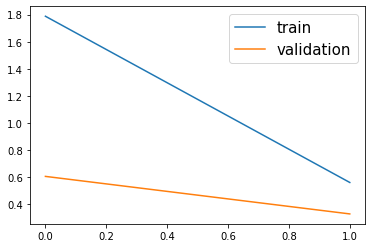

In epoch: 3
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.2534 || batch_loss: 0.2832 || avg_batch_loss: 0.3345 || batch_acc: 0.9514 || avg_batch_acc: 0.9514 
Epoch 3 train_loss: 0.3345098499071936
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.0735 || batch_loss: 0.2300 || avg_batch_loss: 0.2407 || batch_acc: 0.9440 || avg_batch_acc: 0.9470 
Epoch 3 valid_loss: 0.24067793106900165


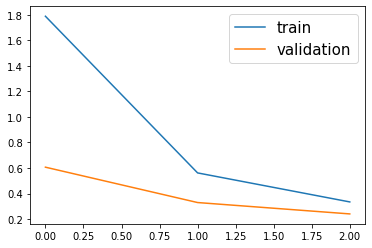

In epoch: 4
train_data size: 245821
Percent: [----------------------------->] 100% || batch_time: 0.2543 || batch_loss: 0.1724 || avg_batch_loss: 0.2334 || batch_acc: 0.9692 || avg_batch_acc: 0.9692 
Epoch 4 train_loss: 0.23341220051372186
valid_data size: 27313
Percent: [----------------------------->] 100% || batch_time: 0.0745 || batch_loss: 0.2021 || avg_batch_loss: 0.2029 || batch_acc: 0.9611 || avg_batch_acc: 0.9526 
Epoch 4 valid_loss: 0.20292230686761736


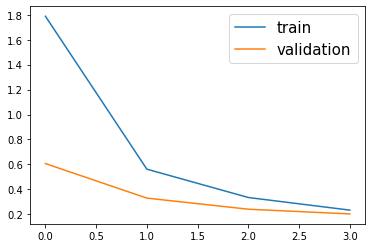

In epoch: 5
train_data size: 245821
Percent: [------------>                 ] 44% || batch_time: 0.2734 || batch_loss: 0.2550 || avg_batch_loss: 0.1738 || batch_acc: 0.9653 || avg_batch_acc: 0.9653 

KeyboardInterrupt: ignored

In [13]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
START_EPOCH, N_EPOCHS = 1, 8
TRAIN_BATCH_SIZE, VALID_BATCH_SIZE = 32,32
max_dev_acc, argmax_dev_acc = -1, -1
patience = 100

# model to device
model.to(DEVICE)

MODEL_NAME = "nested-LSTM"
total_train_loss = []
total_val_loss = []


for epoch_id in range(START_EPOCH,N_EPOCHS+1):
  # check for patience
  if (epoch_id-argmax_dev_acc)>patience:
    print("patience count reached. early stopping initiated")
    print("max_dev_acc: {}, argmax_dev_acc: {}".format(max_dev_acc, argmax_dev_acc))
    break
  # print epoch
  print(f"In epoch: {epoch_id}")
  # train loss and backprop
  train_loss = 0.
  train_acc = 0.
  train_acc_count = 0.
  print("train_data size: {}".format(len(train_data)))
  train_data_iter = batch_iter(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
  nbatches = int(np.ceil(len(train_data)/TRAIN_BATCH_SIZE))
  
  for batch_id, (batch_labels,batch_sentences) in enumerate(train_data_iter):
    optimizer.zero_grad()
    st_time = time.time()
    # set batch data
    batch_labels, batch_lengths = labelize(batch_labels, vocab)
    batch_idxs, batch_lengths_, batch_char_lengths = char_tokenize(batch_sentences, vocab, return_nchars=True)
    assert (batch_lengths_==batch_lengths).all()==True
    batch_idxs = [batch_idxs_.to(DEVICE) for batch_idxs_ in batch_idxs]
    batch_char_lengths = [batch_char_lengths_.to(DEVICE) for batch_char_lengths_ in batch_char_lengths]
    batch_lengths = batch_lengths.to(DEVICE)
    batch_labels = batch_labels.to(DEVICE)
    # forward
    model.train()
    loss = model(batch_idxs, batch_char_lengths, batch_lengths, targets=batch_labels)
    batch_loss = loss.cpu().detach().numpy()
    train_loss += batch_loss
    # backward
    loss.backward()
    optimizer.step()
    # compute accuracy in numpy
    if batch_id%10000==0:
      train_acc_count += 1
      model.eval()
      with torch.no_grad():
        _, batch_predictions = model(batch_idxs, batch_char_lengths, batch_lengths, targets=batch_labels)
        model.train()
        batch_labels = batch_labels.cpu().detach().numpy()
        batch_lengths = batch_lengths.cpu().detach().numpy()
        ncorr,ntotal = batch_accuracy_func(batch_predictions,batch_labels,batch_lengths)
        batch_acc = ncorr/ntotal
        train_acc += batch_acc 

    # update progress
    progressBar(batch_id+1,
          int(np.ceil(len(train_data) / TRAIN_BATCH_SIZE)), 
          ["batch_time","batch_loss","avg_batch_loss","batch_acc","avg_batch_acc"],
          [time.time()-st_time,batch_loss,train_loss/(batch_id+1),batch_acc,train_acc/train_acc_count]) 
  print(f"\nEpoch {epoch_id} train_loss: {train_loss/(batch_id+1)}")
  
  mean_batch_loss = train_loss / nbatches
  total_train_loss.append(mean_batch_loss)


  # save model and optimizer every epoch
  model_name = MODEL_NAME + "_epoch_" + str(epoch_id) + '.pt'
  torch.save(model.state_dict(),
            '/content/drive/MyDrive/NLP/CW2/'+model_name)
    
  # save optimizer
  optimizer_name = MODEL_NAME + "_optimizer_epoch_" + str(epoch_id) + '.pt'
  torch.save(optimizer.state_dict(), 
        '/content/drive/MyDrive/NLP/CW2/'+optimizer_name)


  # valid loss
  valid_loss = 0.
  valid_acc = 0.
  print("valid_data size: {}".format(len(valid_data)))
  valid_data_iter = batch_iter(valid_data, batch_size=VALID_BATCH_SIZE, shuffle=False)
  val_nbatches = int(np.ceil(len(valid_data)/VALID_BATCH_SIZE))
  
  for batch_id, (batch_labels,batch_sentences) in enumerate(valid_data_iter):
    st_time = time.time()
    # set batch data
    batch_labels, batch_lengths = labelize(batch_labels, vocab)
    batch_idxs, batch_lengths_, batch_char_lengths = char_tokenize(batch_sentences, vocab, return_nchars=True)
    assert (batch_lengths_==batch_lengths).all()==True
    batch_idxs = [batch_idxs_.to(DEVICE) for batch_idxs_ in batch_idxs]
    batch_char_lengths = [batch_char_lengths_.to(DEVICE) for batch_char_lengths_ in batch_char_lengths]
    batch_lengths = batch_lengths.to(DEVICE)
    batch_labels = batch_labels.to(DEVICE)
    # forward
    model.eval()
    with torch.no_grad():
      batch_loss, batch_predictions = model(batch_idxs, batch_char_lengths, batch_lengths, targets=batch_labels)
    model.train()        
    valid_loss += batch_loss
    # compute accuracy in numpy
    batch_labels = batch_labels.cpu().detach().numpy()
    batch_lengths = batch_lengths.cpu().detach().numpy()
    ncorr,ntotal = batch_accuracy_func(batch_predictions,batch_labels,batch_lengths)
    batch_acc = ncorr/ntotal
    valid_acc += batch_acc
    # update progress
    progressBar(batch_id+1,
          int(np.ceil(len(valid_data) / VALID_BATCH_SIZE)), 
          ["batch_time","batch_loss","avg_batch_loss","batch_acc","avg_batch_acc"], 
          [time.time()-st_time,batch_loss,valid_loss/(batch_id+1),batch_acc,valid_acc/(batch_id+1)]) 
  print(f"\nEpoch {epoch_id} valid_loss: {valid_loss/(batch_id+1)}")
  
  mean_val_loss = valid_loss / val_nbatches
  total_val_loss.append(mean_val_loss)
    
  if epoch_id >= 2:
      plt.figure(epoch_id)
      plt.plot(total_train_loss, label='train')
      plt.plot(total_val_loss, label='validation')
      plt.legend(fontsize=15)
      plt.show()

## Testing

In [14]:
model = load_model(vocab)
model = model.cuda()
pretrained_model_name = 'nested-LSTM_epoch_4.pt'
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/CW2/'+pretrained_model_name))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Number of parameters in the model: 80912328


<All keys matched successfully>

#### load test data sets: jfleg and bea60k

In [15]:
# load test data jfleg
test_data = load_data('/content/neuspell/data/traintest/','test.jfleg','test.jfleg.noise')
test_data_2 = load_data('/content/neuspell/data/traintest/','test.bea60k','test.bea60k.noise')

1601it [00:00, 357984.90it/s]
1601it [00:00, 1209053.06it/s]
0it [00:00, ?it/s]

loaded tuples of (corr,incorr) examples from /content/neuspell/data/traintest/


63044it [00:00, 463093.11it/s]
63044it [00:00, 1575519.27it/s]

loaded tuples of (corr,incorr) examples from /content/neuspell/data/traintest/


#### Inference on jfleg dataset

In [16]:
predictions = model_predictions(model,test_data,vocab,DEVICE)
model_inference(model = model, data = test_data, topk=1, device = DEVICE, vocab_=vocab)

2it [00:00, 14.36it/s]

###############################################
data size: 1601


101it [00:07, 13.88it/s]
2it [00:00, 14.96it/s]

total inference time for this data is: 7.280506 secs
###############################################
data size: 1601


101it [00:07, 13.96it/s]



Epoch None valid_loss: 0.20937387383367756
total inference time for this data is: 7.242233 secs
###############################################
total token count: 33625
_corr2corr:31052, _corr2incorr:532, _incorr2corr:1507, _incorr2incorr:534
accuracy is 0.9682973977695167
word correction rate is 0.7383635472807447
###############################################


[{'id': 0,
  'noised': 'So I think we would not be live if our ancestors did not develop siences and tecnologies .',
  'original': 'So I think we would not be alive if our ancestors did not develop sciences and technologies .',
  'predicted': 'So I think we would not be live if our ancestors did not develop sciences and technologies .',
  'topk': [],
  'topk_prediction_probs': [],
  'topk_reranker_losses': []},
 {'id': 1,
  'noised': "Imagine yourself you are working in factory just to do one thing like put air a on car if they fire you you will be destroyed , becouse you do n't know more than to put air a in car .",
  'original': "Imagine yourself you are working in factory just to do one thing like put air a on car if they fire you you will be destroyed , because you do n't know more than to put air a in car .",
  'predicted': 'Imagine yourself you are working in factory just to do one thing like put air a on car if they fire you you will be destroyed , because you do not know more t

#### Inference on bea60k dataset

In [17]:
model_inference(model = model, data = test_data_2, topk=1, device = DEVICE, vocab_=vocab)

0it [00:00, ?it/s]

###############################################
data size: 63044


3941it [03:58, 16.50it/s]



Epoch None valid_loss: 0.3297503336794264
total inference time for this data is: 238.896106 secs
###############################################
total token count: 1032061
_corr2corr:936172, _corr2incorr:25825, _incorr2corr:47236, _incorr2incorr:22828
accuracy is 0.9528584066251898
word correction rate is 0.6741836035624572
###############################################


[{'id': 0,
  'noised': 'I WANT TO THAK YOU FOR PREPARING SUCH A GOOD PROGRAMME FOR US AND ESPECIALLY FOR TAKING US ON THE RIVER TRIP TO GREENWICH .',
  'original': 'I WANT TO THANK YOU FOR PREPARING SUCH A GOOD PROGRAMME FOR US AND ESPECIALLY FOR TAKING US ON THE RIVER TRIP TO GREENWICH .',
  'predicted': 'I WANT TO THAK YOU FOR PREPARING SUCH A GOOD PROGRAMME FOR US AND ESPECIALLY FOR TAKING US ON THE RIVER TRIP TO GREENWICH .',
  'topk': [],
  'topk_prediction_probs': [],
  'topk_reranker_losses': []},
 {'id': 1,
  'noised': 'IN MY OPINION FAMOUS PEOPLE ARE BEING OBLIGED TO PAY A PRICE FOR BEING FAMOUS THAT , IN SOME CASS , COSTS MORE THAN THEY DESERVE TO PAY .',
  'original': 'IN MY OPINION FAMOUS PEOPLE ARE BEING OBLIGED TO PAY A PRICE FOR BEING FAMOUS THAT , IN SOME CASES , COSTS MORE THAN THEY DESERVE TO PAY .',
  'predicted': 'IN MY OPINION FAMOUS PEOPLE ARE BEING OBLIGED TO PAY A PRICE FOR BEING FAMOUS THAT , IN SOME CASS , COSTS MORE THIS THEY DESERVE TO PAY .',
  'topk': [],


## Loss Check

In [18]:
total_train_loss

[1.7879440707950598,
 0.5616578995498696,
 0.3345098499071936,
 0.23341220051372186]

In [19]:
total_val_loss

[0.6065135649830731,
 0.32968913303116726,
 0.24067793106900165,
 0.20292230686761736]